# Import required repositories

In [ ]:
!pip install langdetect

     |████████████████████████████████| 981 kB 8.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=cfe8fbdcbefe972dceacc8fee68e2636918097f195d15268526f9fbab6bb6622
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import langdetect
import string
import scipy
from datetime import datetime
from itertools import cycle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier

from sklearn.datasets import make_classification

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, multilabel_confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc

from sklearn.pipeline import Pipeline

import seaborn as sns

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Movie Data Loading

In [ ]:
# Set data directory
DRIVE_ROOT = '/content/drive'
DATA_DIRECTORY = '/My Drive/CS-UA480/Data'

In [ ]:
# Get data from google drive
from google.colab import drive
drive.mount(DRIVE_ROOT) 

Mounted at /content/drive


In [ ]:
# # Load preprocessed train/test/val data
df_train = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/train.csv')
df_test = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/test.csv')
df_val = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/val.csv')

In [ ]:
df_train.head()

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Night Moves,"When Los Angeles private detective, Harry Mose...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,loudQUIETloud: A Film About the Pixies,When college rock darlings the Pixies broke up...,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Holy Flame of the Martial World,This internationally popular tale of a brother...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dead Souls,"On his 18th birthday, Johnny finds out that he...",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Sinister,Found footage helps a true-crime novelist real...,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [ ]:
attributes = list(df_train.columns[2:])

In [ ]:
# Data Split for overview and genres
X_train = df_train.overview
X_test = df_test.overview
X_val = df_val.overview

Y_train = df_train[attributes].to_numpy()
Y_test = df_test[attributes].to_numpy()
Y_val = df_val[attributes].to_numpy()

In [ ]:
X_rem = pd.concat([X_val, X_train], axis=0)
Y_rem = np.concatenate([Y_val, Y_train], axis=0)

In [ ]:
Y_val.shape

(4567, 20)

# TFIDF Vectorizer

Tokenize X and remove stopwords and punctuation

In [ ]:
# Load all stopwords and puncuation
stopwords_punct = set(stopwords.words('english')+list(string.punctuation))

In [ ]:
# Removal function
def tokenize_remove_stop(overview):
  return [word for word in word_tokenize(overview.lower()) if word not in stopwords_punct]

In [ ]:
# Apply the removal
X_rem_tokenized_nonstop = X_rem.apply(tokenize_remove_stop)
X_test_tokenized_nonstop = X_test.apply(tokenize_remove_stop)

Define Different Transformer for X

TFIDF:

In [ ]:
tfidf_transformer = TfidfVectorizer(ngram_range=(1, 1))
tfidf_params = {'tfidf__max_df': (0.25, 0.5, 0.75), 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]}

In [ ]:
X_rem_tfidf = tfidf_transformer.fit_transform(X_rem_tokenized_nonstop.apply(lambda x: " ".join(x)))
X_test_tfidf = tfidf_transformer.transform(X_test_tokenized_nonstop.apply(lambda x: " ".join(x)))

## Define scoring function for future use

In [ ]:
# Define the precision metric
def macro_label_based_precision(y, y_pred, detailed=False):
  # Calculate Averaged Macro Precision
  # Calculate TP along columns
  true_positive = np.sum(np.logical_and(y, y_pred), axis = 0).astype('float64')
  # Calculate TP + FP along columns
  true_positive_false_positive = np.sum(y_pred, axis = 0).astype('float64')
  # Calculate Precision
  precision = np.divide(true_positive, true_positive_false_positive, out=np.zeros_like(true_positive), where=true_positive_false_positive!=0)
  if detailed:
    return precision
  else:
    return np.mean(precision)


In [ ]:
# Define the recall metric
def macro_label_based_recall(y, y_pred, detailed=False):
  # Calculate Averaged Macro Recall
  # Calculate TP along columns
  true_positive = np.sum(np.logical_and(y, y_pred), axis = 0).astype('float64')

  # Calculate TP + FN along columns
  true_positive_false_negative = np.sum(y, axis = 0).astype('float64')

  # Calculate Recall
  recall = np.divide(true_positive, true_positive_false_negative, out=np.zeros_like(true_positive), where=true_positive_false_negative!=0)
  if detailed:
    return recall
  else:
    return np.mean(recall)


In [ ]:
# Define the f1 score metric
def macro_label_based_f1(y, y_pred):
  precision = macro_label_based_precision(y, y_pred)
  recall = macro_label_based_recall(y, y_pred)
  return 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

In [ ]:
# Show the performance
def display_performance(y, y_pred, attributes):
  curr_precision = macro_label_based_precision(y, y_pred, True)
  curr_recall = macro_label_based_recall(y, y_pred, True)
  for i in range(len(attributes)):
    print(attributes[i]+": Precision: %f, Recall: %f" % (curr_precision[i], curr_recall[i]))

In [ ]:
# Calculate and display the confusion matrix
def display_confusion_matrix(y, y_pred, attributes):
  confusion_matrixes = multilabel_confusion_matrix(y, y_pred)
  fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25,18))
  for i in range(len(confusion_matrixes)):
    cm = confusion_matrixes[i]
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [value for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape((2,2))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes.ravel()[i])
    axes.ravel()[i].set_title('Confusion matrix of %s'%attributes[i])

In [ ]:
# Display ROC-AUC Graphs
def plot_roc_auc_graph(y, y_score, attributes):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(attributes)):
      fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  lw=2
  plt.figure(figsize=(20,15))
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )
  
  cmap = plt.get_cmap('gist_rainbow')
  colors = [cmap(i) for i in np.linspace(0, 1, len(attributes))]
  for i in range(len(attributes)):
      plt.plot(
          fpr[i],
          tpr[i],
          lw=lw,
          color=colors[i],
          label="ROC curve of class {0} (area = {1:0.2f})".format(attributes[i], roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC-AUC Graph of TFIDF+LR")
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
# Define Scorer instance for future use
macro_f1_scoring = make_scorer(macro_label_based_f1, greater_is_better=True)

## Multi-label Logistic Regression Classifier

In [ ]:
# Create the Classifier class
class multi_label_model(BaseEstimator, ClassifierMixin):

  def __init__(self, model_kind='LR', threshold=0.5, penalty='l2', C=1.0, max_iter=200):
    self.models = []
    self.model_kind = model_kind
    self.penalty = penalty
    self.C = C
    self.max_iter = max_iter
    self.threshold = threshold
  
  # Training function
  def fit(self, X, Y):
    solver = 'lbfgs' if self.penalty=='l2' else 'liblinear'
    if self.model_kind == 'RF':
      self.models = [RandomForestClassifier() for _ in range(Y.shape[1])]
    elif self.model_kind == 'MLP':
      self.models = [MLPClassifier() for _ in range(Y.shape[1])]
    elif self.model_kind == 'SVM':
      self.models = [SVR() for _ in range(Y.shape[1])]
      X = scipy.sparse.csr_matrix(X)
    else:
      self.models = [LogisticRegression(penalty=self.penalty, C=self.C, max_iter=self.max_iter, solver=solver) for _ in range(Y.shape[1])]
    for i in range(len(self.models)):
      self.models[i].fit(X, Y[:, i])
      
  # Prediction function
  def predict(self, X):
    res = []
    for model in self.models:
      curr_prob = model.predict_proba(X)[:,1]
      res.append((curr_prob>self.threshold).astype(int).reshape((-1,1)))
    return np.concatenate(res, axis=1)
  
  # Probability Prediction function
  def predict_prob(self, X):
    res = []
    for model in self.models:
      curr_prob = model.predict_proba(X)[:,1]
      res.append(curr_prob.reshape((-1,1)))
    return np.concatenate(res, axis=1)

In [ ]:
# Intialize the LR classifier
multi_label_LR_model = multi_label_model(threshold=0.5, penalty='l2')
multi_label_LR_params = {'C' : np.logspace(-4, 4, 6), 'threshold':[0.3, 0.4, 0.5, 0.7], 'penalty':['l1', 'l2'], 'max_iter':[200]}

# Build Baseline: TFIDF+Logistic Regression

In [ ]:
# Training the model
multi_label_LR_model.fit(X_rem_tfidf, Y_rem)

In [ ]:
# Using model on test set to make predictions
y_pred = multi_label_LR_model.predict(X_test_tfidf)

In [ ]:
# Calculate the classfier f1
f1_score(Y_test, y_pred, average='micro')

0.44072183478323396

In [ ]:
# Calculate the macro based f1
macro_label_based_f1(Y_test, y_pred)

0.28513090049386

In [ ]:
display_performance(Y_test, y_pred, attributes)

Action: Precision: 0.760563, Recall: 0.234104
Adventure: Precision: 0.702128, Recall: 0.086162
Animation: Precision: 0.923077, Recall: 0.072727
Comedy: Precision: 0.757344, Recall: 0.433163
Crime: Precision: 0.577586, Recall: 0.142251
Documentary: Precision: 0.910781, Recall: 0.480392
Drama: Precision: 0.704823, Recall: 0.610468
Family: Precision: 0.852941, Recall: 0.087879
Fantasy: Precision: 0.812500, Recall: 0.059908
Foreign: Precision: 0.000000, Recall: 0.000000
History: Precision: 0.000000, Recall: 0.000000
Horror: Precision: 0.877551, Recall: 0.309353
Music: Precision: 0.617647, Recall: 0.099526
Mystery: Precision: 0.555556, Recall: 0.055351
Romance: Precision: 0.691358, Recall: 0.230453
Science Fiction: Precision: 0.866667, Recall: 0.249315
TV Movie: Precision: 0.000000, Recall: 0.000000
Thriller: Precision: 0.642140, Recall: 0.212860
War: Precision: 0.714286, Recall: 0.161290
Western: Precision: 0.950000, Recall: 0.133803


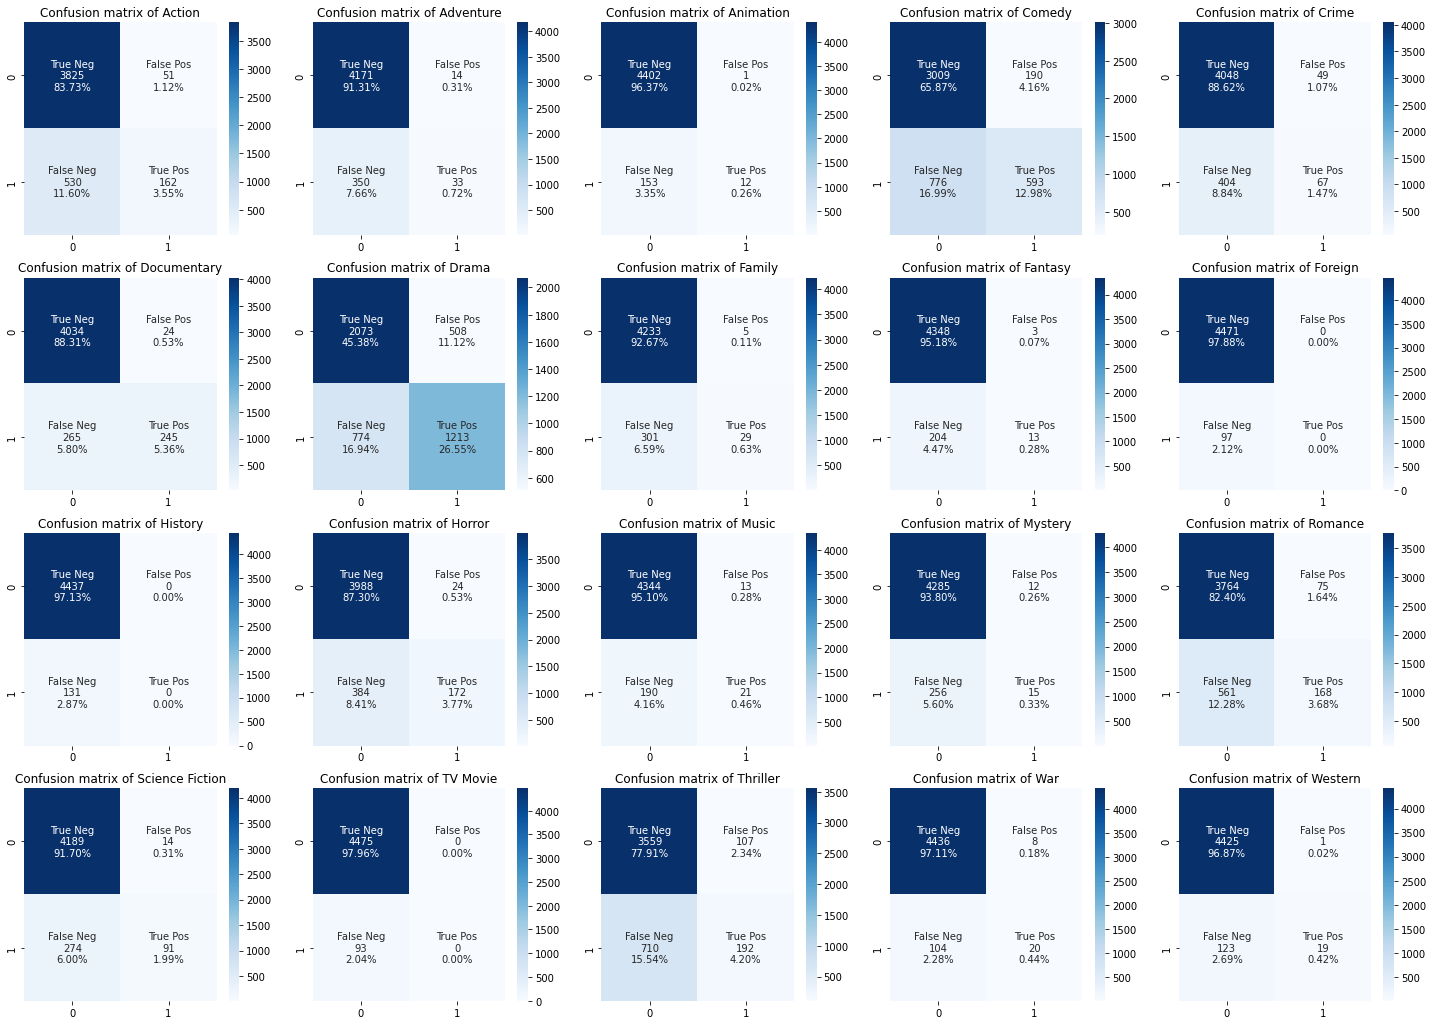

In [ ]:
display_confusion_matrix(Y_test, y_pred, attributes)

From the results above, we realize that the prediction has precision much higher than recall in most of the genres. This means that the prediction is suffering from too much False Negative. This is also explained by the confusion matrixes. Therefore, to improve the performance of prediction, we are expecting to lower the threshold from 0.5.

## Train and Hyperparmeter-tune TFIDF+Logistic Regression model with Grid Search Cross Validation

In [ ]:
# kf = KFold(n_splits=5)
# tfidf_LR_params = {}
# tfidf_LR_params.update(multi_label_LR_params)
# grid_cv = GridSearchCV(estimator=multi_label_model(), param_grid=tfidf_LR_params, scoring=macro_f1_scoring, cv=kf)
# grid_result = grid_cv.fit(X_rem_tfidf, Y_rem_labeled)

In [ ]:
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# grid_result.best_score_

In [ ]:
# grid_result.best_params_

## Train and Evaluate baseline model (TF-IDF+Logistic Regression) with parameters of best performance.

In [ ]:
# Initialize the model
best_LR_model = multi_label_model(model_kind='LR',**{'C': 4.281332398719396, 'max_iter': 200, 'penalty': 'l2', 'threshold': 0.3})

In [ ]:
# Training the model
start_time = datetime.now()
best_LR_model.fit(X_rem_tfidf, Y_rem)
training_time = datetime.now() - start_time
print("Training time in seconds: ", training_time.total_seconds())

Training time in seconds:  48.41729


In [ ]:
# Prediction
y_pred = best_LR_model.predict(X_test_tfidf)
y_score = best_LR_model.predict_prob(X_test_tfidf)

In [ ]:
macro_label_based_f1(Y_test, y_pred)

In [ ]:
# Calculate the model f1 score ont the test set
result = f1_score(Y_test, y_pred, average='micro')
auc = roc_auc_score(Y_test, y_score, average='micro')
print("The final micro f1 socre for the baseline model: {:.3f}".format(result))
print("The final auc socre for the baseline model: {:.3f}".format(auc))

The final micro f1 socre for the baseline model: 0.583
The final auc socre for the baseline model: 0.910


In [ ]:
accuracy_score(Y_test, y_pred)

0.1665936952714536

In [ ]:
precision_score(Y_test, y_pred, average='micro')

0.5799045006603678

In [ ]:
recall_score(Y_test, y_pred, average='micro')

0.5857362750128271

In [ ]:
# Display the genre result
display_performance(Y_test, y_pred, attributes)

Action: Precision: 0.561080, Recall: 0.570809
Adventure: Precision: 0.448276, Recall: 0.305483
Animation: Precision: 0.741176, Recall: 0.381818
Comedy: Precision: 0.559051, Recall: 0.739956
Crime: Precision: 0.559796, Recall: 0.467091
Documentary: Precision: 0.785417, Recall: 0.739216
Drama: Precision: 0.586848, Recall: 0.826371
Family: Precision: 0.540179, Recall: 0.366667
Fantasy: Precision: 0.549550, Recall: 0.281106
Foreign: Precision: 0.000000, Recall: 0.000000
History: Precision: 0.485714, Recall: 0.129771
Horror: Precision: 0.690979, Recall: 0.647482
Music: Precision: 0.620690, Recall: 0.341232
Mystery: Precision: 0.433962, Recall: 0.254613
Romance: Precision: 0.507266, Recall: 0.526749
Science Fiction: Precision: 0.731061, Recall: 0.528767
TV Movie: Precision: 0.200000, Recall: 0.010753
Thriller: Precision: 0.512093, Recall: 0.539911
War: Precision: 0.602273, Recall: 0.427419
Western: Precision: 0.828947, Recall: 0.443662


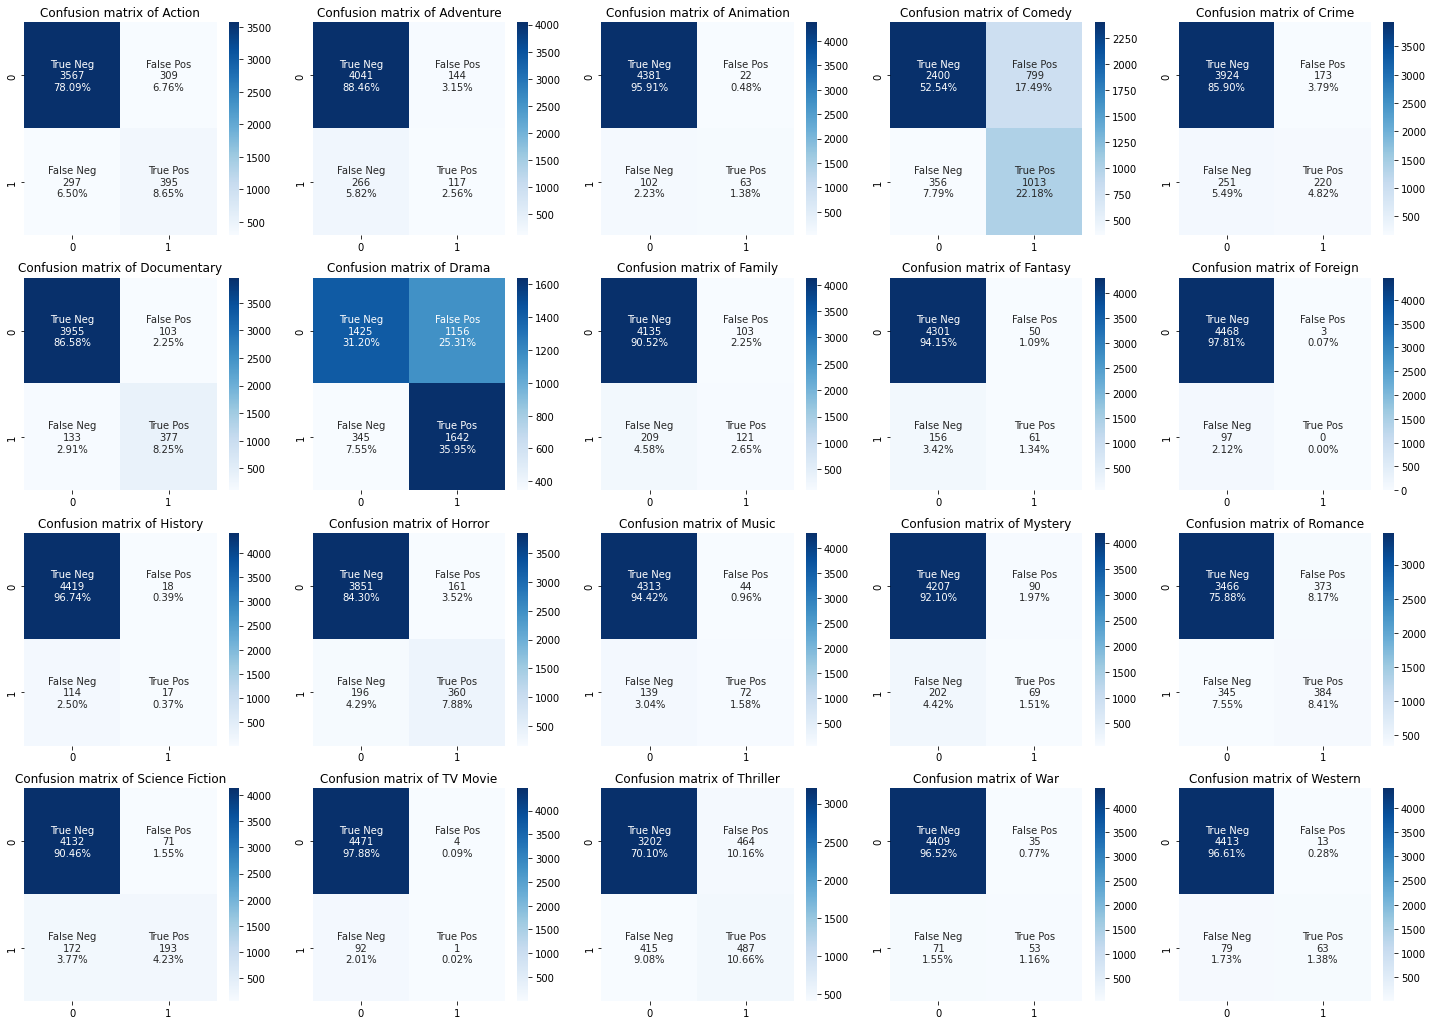

In [ ]:
# Display the confusion matrix
display_confusion_matrix(Y_test, y_pred, attributes)

In [ ]:
accuracy_score(Y_test, y_pred)

0.1665936952714536

In [ ]:
recall_score(Y_test, y_pred, average='micro')

0.5857362750128271

In [ ]:
precision_score(Y_test, y_pred, average='micro')

0.5799045006603678

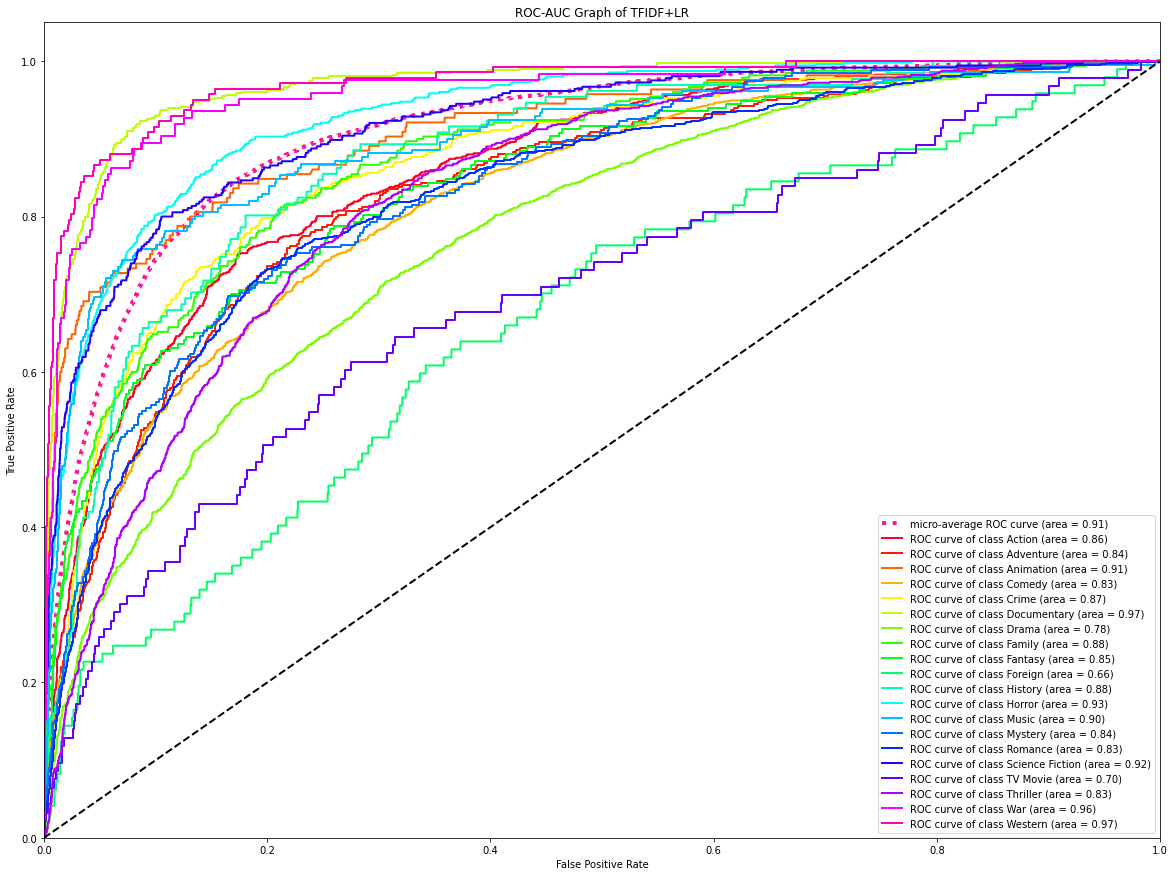

In [ ]:
plot_roc_auc_graph(Y_test, y_score, attributes)